# Hands-On Stochastic Gradient Descent
***

In this notebook we'll implement a rudimentary Stochastic Gradient Descent algorithm to learn the weights in simple linear regression.  Then we'll see if we can make it more efficient.  Finally, we'll investigate some graphical strategies for diagnosing convergence and tuning parameters. 

**Note**: There are some helper functions at the bottom of this notebook.  Scroll down and evaluate those before proceeding. 


In [1]:
import numpy as np 
import matplotlib.pylab as plt 
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style('onedork')

### Part 1: Setting Up Simulated Data and a Sanity Check 
***

We'll work with simulated data for this exercise where our generative model is given by 

$$
Y = 1 + 2X + \epsilon \textrm{ where} \epsilon \sim N(0, \sigma^2)
$$

**Part A**: The following function will generate data from the model. We'll grab a training set of size $n=100$ and a validation set of size $n = 50$.  

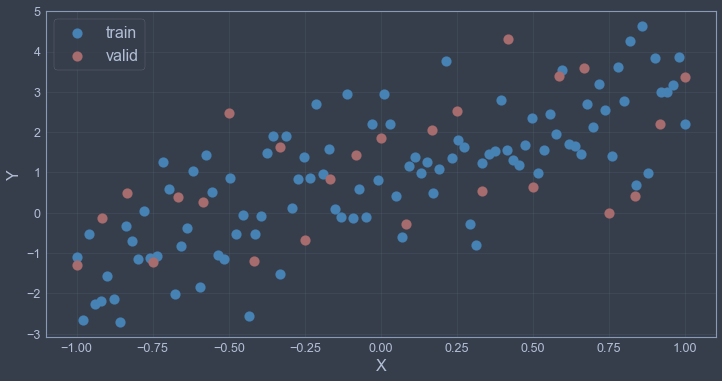

In [3]:
def dataGenerator(n, sigsq=1.0, random_state=1236):
    np.random.seed(random_state)
    x_train = np.linspace(-1, 1, n)
    x_valid = np.linspace(-1, 1, int(n/4))
    y_train = 1 + 2 * x_train + np.random.randn(n)
    y_valid = 1 + 2 * x_valid + np.random.randn(int(n/4))
    return x_train, x_valid, y_train, y_valid 

x_train, x_valid, y_train, y_valid = dataGenerator(100)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.scatter(x_train, y_train, color="steelblue", s=100, label="train")
ax.scatter(x_valid, y_valid, color="#a76c6e", s=100, label="valid")
ax.grid(alpha=0.25)
ax.set_axisbelow(True)
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.legend(loc="upper left", fontsize=16);

**Part B**: Since we're going to be implementing things ourselves, we're going to want to prepend the data matrices with a column of ones so we can fit a bias term.  We can do this using numpy's [column_stack](https://docs.scipy.org/doc/numpy/reference/generated/numpy.column_stack.html) function. 

In [4]:
X_train = np.column_stack((np.ones_like(x_train), x_train))
X_valid = np.column_stack((np.ones_like(x_valid), x_valid))

**Part C**: Finally, let's fit a linear regression model with sklearn's LinearRegression class and print the coefficients so we know what we're shooting for. 

In [5]:
from sklearn.linear_model import LinearRegression 
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
print("sklearn says the coefficients are ", reg.coef_)

sklearn says the coefficients are  [0.90918343 2.20093262]


**Part D**: The last thing we'll do is visualize the surface of the RSS, of which we're attempting to find the minimum. Does it looks like the parameters reported by sklearn lie at the bottom of the RSS surface?  

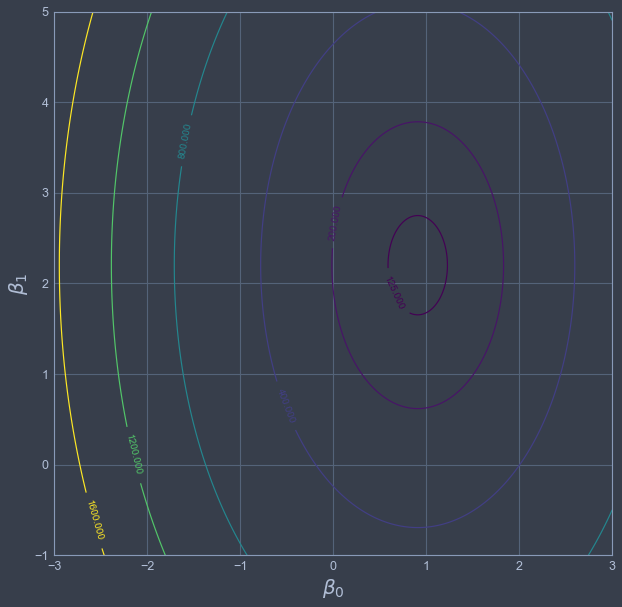

In [6]:
plotsurface(X_train, y_train)

### Part 2: Implementing and Improving SGD 
***


**Part A**: Now it's time to implement Stochastic Gradient Descent.  Most of the code in the function sgd has been written for you.  Your job is to fill in the values of the partial derivatives in the appropriate places.  Recall that the update scheme is given by 

$$
\begin{eqnarray}
\beta_0 &\leftarrow& \beta_0 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] \\
\beta_1 &\leftarrow& \beta_1 - \eta \cdot 2 \cdot \left[(\beta_0 + \beta_1x_i) -y_i \right] x_i\\
\end{eqnarray}
$$

Note that the function parameter beta is a numpy array containing the initial guess for the solve. The numpy array bhist stores the approximation of the betas after each iteration for plotting and diagnostic purposes.  

In [9]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # loop over training examples 
        for index in shuffled_inds:
            prediction_error = np.dot(beta, X[index]) - y[index]
            beta = beta - eta * 2* prediction_error * X[index]
            # prediction_error = beta[0] + beta[1] * X[index][1] - y[index]
            # beta[0] = beta[0] - eta * 2 * prediction_error
            # beta[1] = beta[1] - eta * 2 * prediction_error * X[index][1]


        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

Wall time: 399 ms
beta_0 = 0.90668, beta_1 = 2.20111


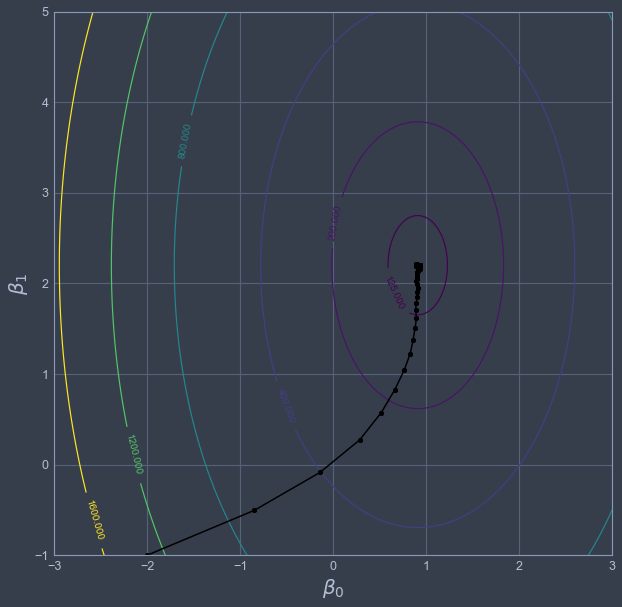

In [10]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.0025, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

**Part B**: Thinking about the case where we have more than two features, can you think of a way to vectorize the stochastic gradient update of the parameters? When you see it, go back to the sgd function and improve it. 


In [11]:
def sgd(X, y, beta, eta=0.1, num_epochs=100):
    """
    Peform Stochastic Gradient Descent 
    
    :param X: matrix of training features 
    :param y: vector of training responses 
    :param beta: initial guess for the parameters
    :param eta: the learning rate 
    :param num_epochs: the number of epochs to run 
    """
    
    # initialize history for plotting 
    bhist = np.zeros((num_epochs+1, len(beta)))
    bhist[0,0], bhist[0,1] = beta[0], beta[1]
    
    # perform epochs 
    for epoch in range(1, num_epochs+1):
        
        # shuffle indices 
        shuffled_inds = list(range(X.shape[0]))
        np.random.shuffle(shuffled_inds)
        
        # loop over training examples 
        for index in shuffled_inds:
            prediction_error = np.dot(beta, X[index]) - y[index]
            beta = beta - eta * 2* prediction_error * X[index]

        # save history 
        bhist[epoch, :] = beta
        
    # return bhist. Last row 
    # are the learned parameters. 
    return bhist 

**Part C**: Now that you have created this beautiful solver, go back and break it by playing with the learning rate. Does the learning rate have the effect on convergence that you expect when visualized in the surface plot? 


Wall time: 406 ms
beta_0 = 0.51548, beta_1 = 0.57952


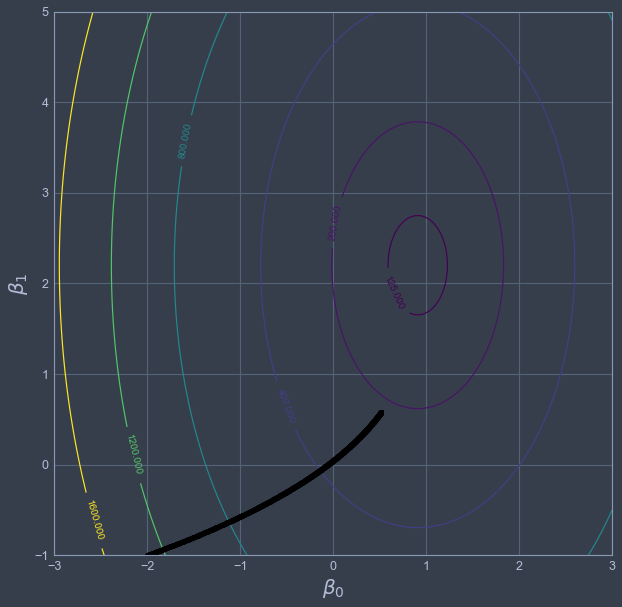

In [19]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

# Training 
%time bhist = sgd(X_train, y_train, beta=beta_start, eta=0.00001, num_epochs=1000)

# Print and Plot 
print("beta_0 = {:.5f}, beta_1 = {:.5f}".format(bhist[-1][0], bhist[-1][1]))
plotsurface(X_train, y_train, bhist=bhist)

### Part 3: Graphical Diagnosis of Convergence 
***

A common way to monitor the convergence of SGD and to tune hyperparameters (like learning rate and regularization strength) is to make a plot of how the loss function evolves during the training process. That is, we plot the value of the loss function periodically and see if it looks like it's reached a minimum, or see if it's jumping around a lot.  Normally we'd record the value of the loss function as we train, but we'll use the beta histories returned by our solver.  Finally, using the MSE instead of the RSS is a popular choice, so we'll do that.  

**Part A**: Modify the function below to take in a beta history and a data set and return a vector of MSE values for each epoch. 

In [20]:
def MSE_hist(X, y, bhist):
    mse = np.zeros(bhist.shape[0])
    for epoch in range(bhist.shape[0]):
        beta = bhist[epoch, :]
        pred = np.matmul(X, beta)
        mse[epoch] = np.mean((y - pred)**2)
    return mse

**Part B**: Next we'll take the MSE history that we just computed and plot it vs epoch number. Based on your plot, would you say that your MSE has converged? 

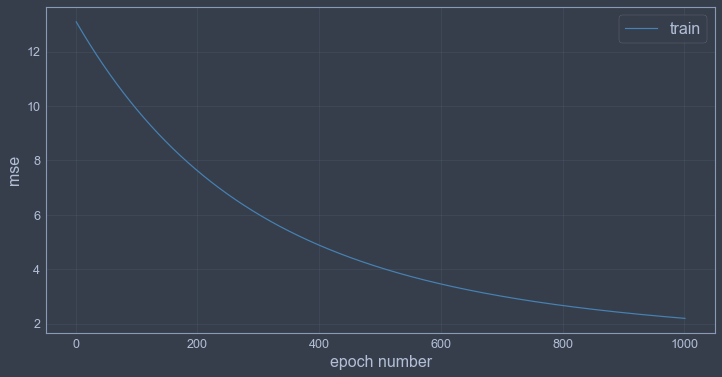

In [27]:
mse_train = MSE_hist(X_train, y_train, bhist)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,len(mse_train)+1), mse_train, color="steelblue", label="train")
ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

**Part C**: Go back up and change the value of the learning rate to bigger and smaller values (you might also have to adjust the max epochs).  Do the different learning rates have the effect on the MSE plots that you would expect? 

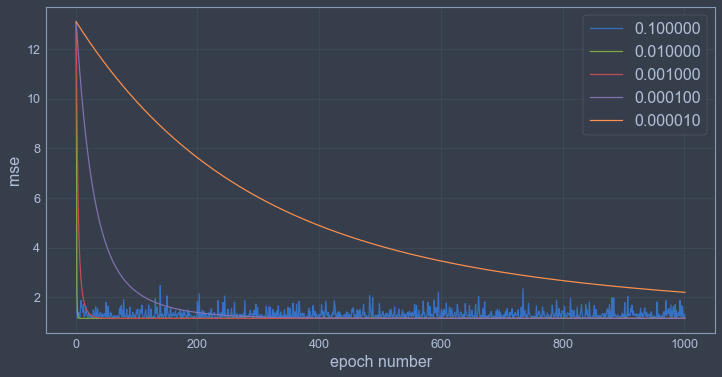

In [30]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
for eta in [0.1, 0.01, 0.001, 0.0001, 0.00001]: 
    # Training 
    bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=1000)
    mse_train = MSE_hist(X_train, y_train, bhist)
    ax.plot(range(1,len(mse_train)+1), mse_train, label='%f'%eta)

ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

**Part D**: OK, now for the real question.  Is the MSE on the training data the best thing to look at when deciding if our training algorithm has converged? 

In [ ]:
def acc(X, y, bhist):
    acc = np.zeros(bhist.shape[0])
    for epoch in range(bhist.shape[0]):
        beta = bhist[epoch, :]
        pred = np.matmul(X, beta)
        mse[epoch] = np.mean((y - pred)**2)
    return acc

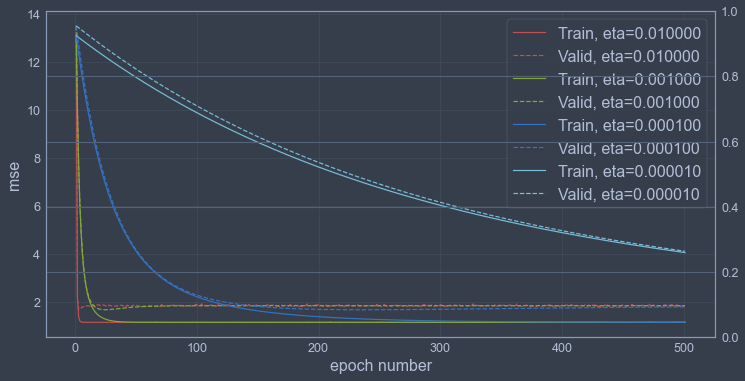

In [36]:
# Start at (-2,1)
beta_start = np.array([-2.0, -1.0])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
right_ax = ax.twinx()
for eta, color in zip([0.01, 0.001, 0.0001, 0.00001], ['r', 'g', 'b', 'c']):
    bhist = sgd(X_train, y_train, beta=beta_start, eta=eta, num_epochs=500)
    mse_valid = MSE_hist(X_valid, y_valid, bhist)
    mse_train = MSE_hist(X_train, y_train, bhist)
    ax.plot(range(1,len(mse_train)+1), mse_train, label='Train, eta=%f'%eta, color=color)
    ax.plot(range(1,len(mse_train)+1), mse_valid, label='Valid, eta=%f'%eta, linestyle='--', color=color)


ax.set_xlabel("epoch number", fontsize=16)
ax.set_ylabel("mse", fontsize=16);
ax.grid(alpha=0.25)
ax.legend(loc="upper right", fontsize=16);

### Helper Functions
***

In [2]:
mycolors = {"blue": "steelblue", "red":"#a76c6e",  "green":"#6a9373", "smoke": "#f2f2f2"}

def eval_RSS(X, y, b0, b1):
    rss = 0 
    for ii in range(len(df)):
        xi = df.loc[ii, "x"]
        yi = df.loc[ii, "y"]
        rss += (yi - (b0 + b1 * xi)) ** 2
    return rss

def plotsurface(X, y, bhist=None):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 300), np.linspace(-1, 5, 300))
    Z = np.zeros((xx.shape[0], yy.shape[0]))
    for ii in range(X.shape[0]):
        Z += (y[ii] - xx - yy * X[ii,1]) ** 2
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    levels = [125, 200] + list(range(400,2000,400))
    CS = ax.contour(xx, yy, Z, levels=levels)
    ax.clabel(CS, CS.levels, inline=True, fontsize=10)
    ax.set_xlim([-3,3])
    ax.set_ylim([-1,5])
    ax.set_xlabel(r"$\beta_0$", fontsize=20)
    ax.set_ylabel(r"$\beta_1$", fontsize=20)
    if bhist is not None:
        for ii in range(bhist.shape[0]-1):
            x0 = bhist[ii][0]
            y0 = bhist[ii][1]
            x1 = bhist[ii+1][0]
            y1 = bhist[ii+1][1]
            ax.plot([x0, x1], [y0, y1], color="black", marker="o", lw=1.5, markersize=5)